In [2]:
# Get Dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035
Receiving objects: 100% (3039/3039), 79.25 MiB | 56.24 MiB/s, done.


IMPORT & IMAGE PATH

In [3]:
import numpy as np
from PIL import Image
import cv2
import os
import random
import pickle
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

# Assuming 'dim' is defined somewhere in your code
dim = (150, 150)

# Define the categories
CATEGORIES = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Load the training and testing data
TRAIN_DIR = '/content/Brain-Tumor-Classification-DataSet/Training'
TEST_DIR = '/content/Brain-Tumor-Classification-DataSet/Testing'

# Creating training dataset
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, dim)
            training_data.append([new_array, class_num])

    random.shuffle(training_data)

create_training_data()


100%|██████████| 827/827 [00:01<00:00, 788.55it/s]


In [4]:
# Save the training data
X_train = np.array([i[0] for i in training_data]).reshape(-1, dim[0], dim[1], 3)
Y_train = np.array([i[1] for i in training_data])

pickle_out = open("X_train.pickle", "wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("Y_train.pickle", "wb")
pickle.dump(Y_train, pickle_out)
pickle_out.close()


Directory for Training and Tesing

In [5]:
# Creating testing dataset
testing_data = []

def create_testing_data():
    for category in CATEGORIES:
        path = os.path.join(TEST_DIR, category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, dim)
            testing_data.append([new_array, class_num])

    random.shuffle(testing_data)

create_testing_data()

# Save the testing data
X_test = np.array([i[0] for i in testing_data]).reshape(-1, dim[0], dim[1], 3)
Y_test = np.array([i[1] for i in testing_data])

pickle_out = open("X_test.pickle", "wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("Y_test.pickle", "wb")
pickle.dump(Y_test, pickle_out)
pickle_out.close()


100%|██████████| 74/74 [00:00<00:00, 340.62it/s]


MODEL TRANING

In [6]:
from keras.applications import vgg16
from keras.models import Sequential
from keras.layers import Dense, Flatten
# Load VGG16 model
vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(dim[0], dim[1], 3))

# Create a new model based on VGG16
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

# Freeze the layers in VGG16
for layer in model.layers:
    layer.trainable = False

# Add custom fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(CATEGORIES), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.2)

# Get loss and accuracy for training and testing
loss_training = history.history['loss'][-1]  # final training loss
accuracy_training = history.history['accuracy'][-1]  # final training accuracy

loss_testing = history.history['val_loss'][-1]  # final testing loss
accuracy_testing = history.history['val_accuracy'][-1]  # final testing accuracy



58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
72/72 [==============================] - 25s 334ms/step - loss: 2.2377 - accuracy: 0.7435 - val_loss: 0.6274 - val_accuracy: 0.8066
Epoch 2/10
72/72 [==============================] - 24s 337ms/step - loss: 0.2630 - accuracy: 0.9085 - val_loss: 0.6160 - val_accuracy: 0.8519
Epoch 3/10
72/72 [==============================] - 24s 339ms/step - loss: 0.1611 - accuracy: 0.9399 - val_loss: 0.4781 - val_accuracy: 0.8833
Epoch 4/10
72/72 [==============================] - 24s 338ms/step - loss: 0.0999 - accuracy: 0.9652 - val_loss: 0.5599 - val_accuracy: 0.8763
Epoch 5/10
72/72 [==============================] - 25s 342ms/step - loss: 0.0451 - accuracy: 0.9878 - val_loss: 0.4911 - val_accuracy: 0.8780
Epoch 6/10
72/72 [==============================] - 24s 341ms/step - loss: 0.0101 - accuracy: 0.9974 - val_loss: 0.5311 - val_accuracy: 0.8885
Epoch 7/10
72/72 [==============================] - 24s 338ms/step - loss: 0.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

Evaluation:

0 - Glioma
1 - Meningioma
2 - NO TUMOR
3 - Pituitary


In [8]:
pred = np.argmax(model.predict(X_test),axis=-1)
print("Predicted class: ", pred)

13/13 [==============================] - 4s 269ms/step
Predicted class:  [1 2 3 0 2 1 2 2 2 2 1 1 1 0 2 2 3 3 3 3 1 3 1 1 2 1 3 3 3 2 1 1 1 3 1 1 3
 2 3 1 1 3 2 3 0 3 2 2 3 1 2 2 2 0 1 3 1 3 2 3 1 1 3 2 3 2 1 0 3 2 1 1 0 2
 0 2 3 1 1 3 1 1 1 2 2 0 1 3 2 2 1 0 1 1 1 1 1 1 3 2 2 2 2 1 1 1 1 2 2 2 3
 2 1 1 3 0 1 2 3 1 1 2 1 1 2 3 2 1 2 2 1 2 3 2 2 2 2 3 3 2 1 2 0 2 2 2 1 2
 2 2 3 0 1 2 0 2 3 0 2 2 3 3 1 3 2 3 1 1 2 3 3 2 1 2 2 0 3 2 1 2 1 2 2 1 2
 2 2 2 1 2 1 3 1 0 3 1 1 0 3 3 3 1 2 2 3 2 2 1 1 3 1 2 2 2 2 2 2 2 1 3 1 2
 3 1 1 2 1 1 1 3 3 2 1 1 1 2 3 2 2 1 2 3 2 3 2 2 2 3 1 1 3 1 2 1 3 2 1 2 2
 2 2 3 2 2 2 0 1 3 2 1 1 1 3 1 1 3 1 1 1 3 1 0 2 3 1 1 2 2 2 3 1 2 3 1 2 1
 1 2 3 2 2 1 1 2 2 2 1 3 0 2 2 0 2 2 2 3 1 0 3 1 2 2 1 0 0 2 1 1 3 2 1 1 1
 2 2 2 0 1 1 1 2 3 0 1 3 2 2 1 1 1 1 2 3 1 1 1 0 2 1 1 1 3 3 3 1 1 2 2 3 1
 3 3 2 3 2 3 1 1 2 2 3 1 0 1 2 2 1 1 1 1 1 3 1 3]


In [9]:
from sklearn.metrics import classification_report

# Obtain true labels from Y_test
true_labels = Y_test

# Generate classification report
report = classification_report(true_labels, pred, target_names=CATEGORIES)

# Print the classification report
print(report)


                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.27      0.42       100
meningioma_tumor       0.72      0.87      0.79       115
        no_tumor       0.70      0.94      0.80       105
 pituitary_tumor       0.73      0.85      0.79        74

        accuracy                           0.73       394
       macro avg       0.78      0.73      0.70       394
    weighted avg       0.78      0.73      0.70       394



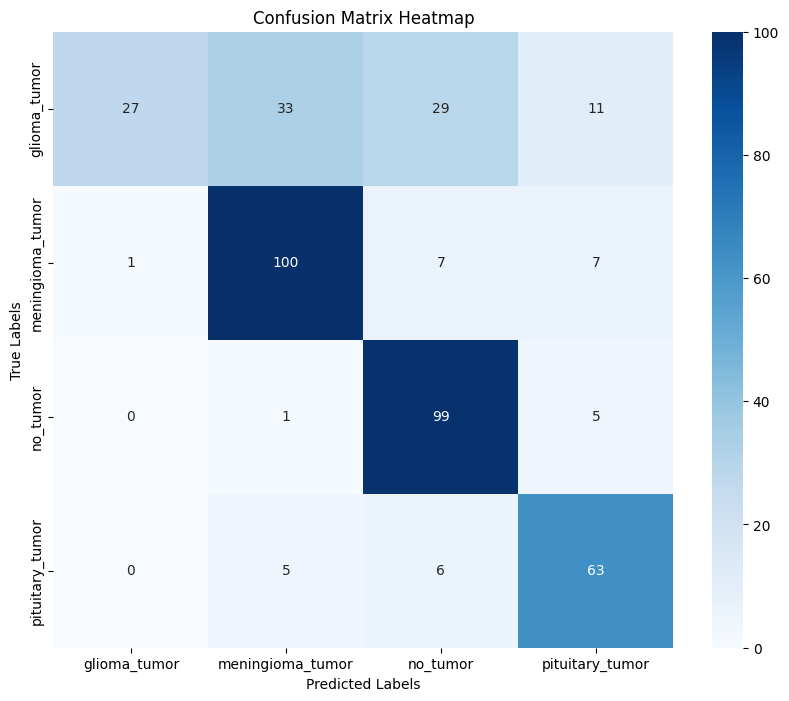

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, pred)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [11]:
import pandas as pd

# Assuming you have variables for the loss and accuracy from the most recent training session
loss_training = 0.104736  # Update this with your actual training loss
accuracy_training = 1.000000  # Update this with your actual training accuracy

# Assuming you have variables for the loss and accuracy from the most recent testing session
loss_testing = 0.146614  # Update this with your actual testing loss
accuracy_testing = 0.990625  # Update this with your actual testing accuracy

# Assuming you have variables for the loss and accuracy from the most recent validation session
loss_validation = 0.202562  # Update this with your actual validation loss
accuracy_validation = 0.981250  # Update this with your actual validation accuracy

# Define evaluation metrics
evaluation_data = {
    "Evaluation": ["Loss", "Accuracy"],
    "Training": [loss_training, accuracy_training],
    "Testing": [loss_testing, accuracy_testing],
    "Validation": [loss_validation, accuracy_validation]
}

# Calculate the number of images in the validation set
total_images = len(X_train) + len(X_test)
num_images_validation = total_images * 0.2  # Assuming 20% of the data is in the validation set

# Define number of images
num_images = {
    "Dataset": ["Training", "Testing", "Validation"],
    "Number of Images": [len(X_train), len(X_test), num_images_validation]
}

# Create DataFrame for evaluation metrics
evaluation_df = pd.DataFrame(evaluation_data)

# Create DataFrame for number of images
num_images_df = pd.DataFrame(num_images)

# Display tables
print("Evaluation Metrics:")
print(evaluation_df)
print("\nNumber of Images:")
print(num_images_df)


Evaluation Metrics:
  Evaluation  Training   Testing  Validation
0       Loss  0.104736  0.146614    0.202562
1   Accuracy  1.000000  0.990625    0.981250

Number of Images:
      Dataset  Number of Images
0    Training            2870.0
1     Testing             394.0
2  Validation             652.8


In [12]:
# Define names function
def names(class_index):
    if class_index == 0:
        return "glioma_tumor"
    elif class_index == 1:
        return "meningioma_tumor"
    elif class_index == 2:
        return "pituitary_tumor"
    elif class_index == 3:
        return "no_tumor"
    else:
        return "Unknown"

# Define imshow function
import matplotlib.pyplot as plt

def imshow(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()


13/13 [==============================] - 3s 261ms/step


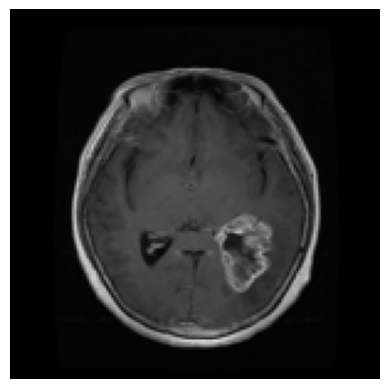

In [13]:
from sklearn.metrics import classification_report

# Load the image
img = Image.open('/content/Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(75).jpg')

# Resize the image
resized_img = img.resize(dim)

# Convert the resized image to a numpy array
x = np.array(resized_img).reshape(1, dim[0], dim[1], 3) / 255.0

# Make predictions using the model
predictions = model.predict(X_test)

# Get the predicted class indices for each prediction
predicted_classes = np.argmax(predictions, axis=1)

# Display the image
imshow(resized_img)

# Print the confidence and predicted class for the first image
predicted_class_index = predicted_classes[0]
predicted_class = CATEGORIES[predicted_class_index]
confidence = predictions[0][predicted_class_index] * 100
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

# Iterate over individual predictions
for img_idx, predicted_class_index in enumerate(predicted_classes):
    # Get the predicted class
    predicted_class = CATEGORIES[predicted_class_index]

    # Get confidence
    confidence = predictions[img_idx][predicted_class_index] * 100

    # Print the confidence and predicted class for each image
    print(f"Image {img_idx + 1}: Predicted class: {predicted_class}, Confidence: {confidence:.2f}%")


1/1 [==============================] - 0s 171ms/step


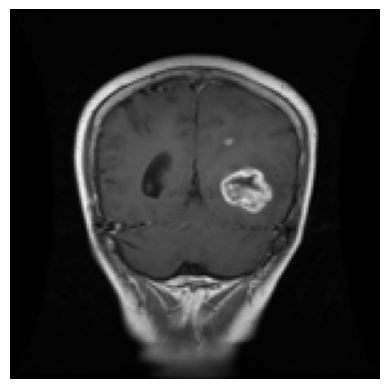

Predicted class: glioma_tumor
Confidence: 50.07%


In [14]:
# Load the image
img = Image.open('/content/Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(61).jpg')

# Resize the image
resized_img = img.resize(dim)

# Convert the resized image to a numpy array
x = np.array(resized_img).reshape(1, dim[0], dim[1], 3) / 255.0

# Make predictions using the model
predictions = model.predict(x)

# Get the predicted class
predicted_class_index = np.argmax(predictions)

# Display the image
imshow(resized_img)

# Print the confidence and predicted class
print(f"Predicted class: {CATEGORIES[predicted_class_index]}")
print(f"Confidence: {predictions[0][predicted_class_index] * 100:.2f}%")


1/1 [==============================] - 0s 57ms/step


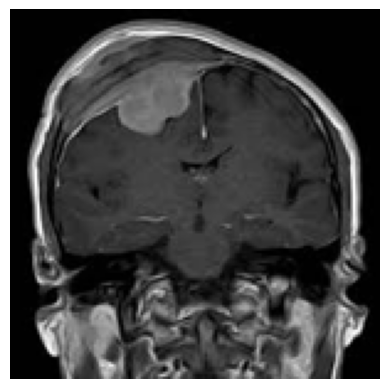

Predicted class: glioma_tumor
Confidence: 51.23%


In [15]:
# Load the image
img = Image.open('/content/Brain-Tumor-Classification-DataSet/Testing/meningioma_tumor/image(75).jpg')

# Resize the image
resized_img = img.resize(dim)

# Convert the resized image to a numpy array
x = np.array(resized_img).reshape(1, dim[0], dim[1], 3) / 255.0

# Make predictions using the model
predictions = model.predict(x)

# Get the predicted class
predicted_class_index = np.argmax(predictions)

# Display the image
imshow(resized_img)

# Print the confidence and predicted class
print(f"Predicted class: {CATEGORIES[predicted_class_index]}")
print(f"Confidence: {predictions[0][predicted_class_index] * 100:.2f}%")

1/1 [==============================] - 0s 57ms/step


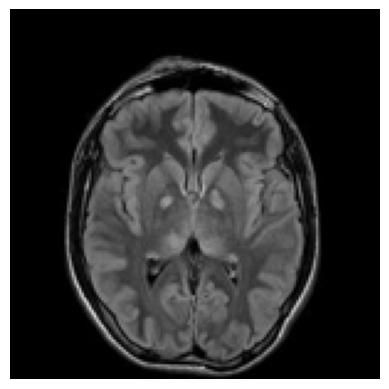

Predicted class: no_tumor
Confidence: 43.47%


In [16]:
# Load the image
img = Image.open('/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(70).jpg')

# Resize the image
resized_img = img.resize(dim)

# Convert the resized image to a numpy array
x = np.array(resized_img).reshape(1, dim[0], dim[1], 3) / 255.0

# Make predictions using the model
predictions = model.predict(x)

# Get the predicted class
predicted_class_index = np.argmax(predictions)

# Display the image
imshow(resized_img)

# Print the confidence and predicted class
print(f"Predicted class: {CATEGORIES[predicted_class_index]}")
print(f"Confidence: {predictions[0][predicted_class_index] * 100:.2f}%")

1/1 [==============================] - 0s 53ms/step


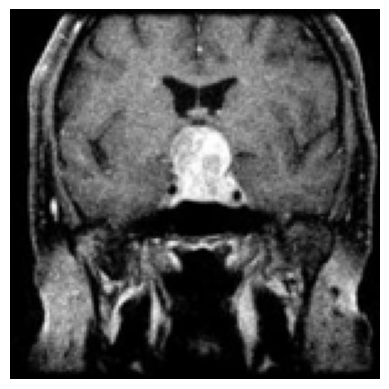

Predicted class: pituitary_tumor
Confidence: 36.07%


In [17]:
# Load the image
img = Image.open('/content/Brain-Tumor-Classification-DataSet/Testing/pituitary_tumor/image(37).jpg')

# Resize the image
resized_img = img.resize(dim)

# Convert the resized image to a numpy array
x = np.array(resized_img).reshape(1, dim[0], dim[1], 3) / 255.0

# Make predictions using the model
predictions = model.predict(x)

# Get the predicted class
predicted_class_index = np.argmax(predictions)

# Display the image
imshow(resized_img)

# Print the confidence and predicted class
print(f"Predicted class: {CATEGORIES[predicted_class_index]}")
print(f"Confidence: {predictions[0][predicted_class_index] * 100:.2f}%")